In [ ]:
# import numpy as np
# import tensorflow as tf
# tf.compat.v1.disable_eager_execution()
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
# sess = tf.compat.v1.Session(config=config)
# import os
# import cv2
import numpy as np
import matplotlib.pyplot as plt
# import porespy as ps
import Utils

: 

In [9]:
image_data = Utils.read_data("Berea_2d25um_binary.raw")
image_data.shape


(1000, 1000, 1000)

In [10]:
voxels = Utils.extract_subvolumes(image_data)
voxels.shape

(64, 250, 256, 256, 1)

In [8]:
# import numpy as np
# from skimage import morphology, measure

In [9]:


# # Load the binary porous image
# image = voxels[0][4]  # Replace with your binary image data

# # Skeletonize the image
# skeleton = morphology.skeletonize(image)

# # Calculate the lineal-path function
# lineal_path = np.sum(skeleton)/np.sum(image)

# # Print the lineal-path value
# print(lineal_path)

In [10]:
# image = ...  # Replace with your binary image data

# # Calculate the two-point correlation function
# correlation = morphology.correlation_2d(image)

# # Print the correlation matrix
# print(correlation)

In [11]:
# # Load the binary porous image
# image = image_data[0]  # Replace with your binary image data

# # Label the connected components
# labels = measure.label(image, connectivity=1)

# # Calculate the two-point cluster function
# unique_labels, label_counts = np.unique(labels, return_counts=True)
# cluster_function = np.sum(label_counts[label_counts > 1]) / np.sum(label_counts)

# # Print the cluster function
# print(cluster_function)

In [15]:
im = voxels[0][0]

In [17]:
# ps.metrics.two_point_correlation(im)

In [61]:

# paths = ps.filters.distance_transform_lin(im, mode='forward', axis=0)
# ps.imshow(paths);

In [62]:
# lpf = ps.metrics.lineal_path_distribution(paths, bins=range(1, 200, 10))

Text(0.5, 1.0, 'Probability Density Function')

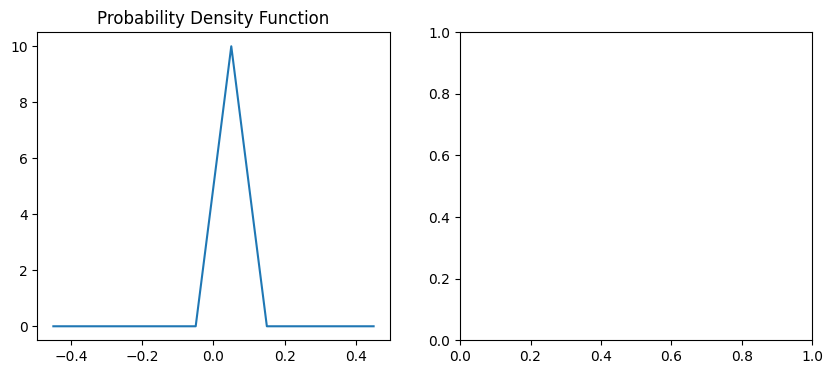

In [18]:
data = ps.metrics.lineal_path_distribution(voxels[0],log=True)
fig, ax = plt.subplots(1, 2, figsize=[10, 4])
ax[0].plot(data.LogL,data.pdf)
# ax[1].plot(data.L,data.cdf)
# ax[2].bar(data.L, data.cdf, data.bin_widths, edgecolor='k')
ax[0].set_title("Probability Density Function")
# ax[1].set_title("Cumulative Density Function")
# ax[2].set_title('Bar Plot');

In [64]:
e = ps.metrics.porosity(im)
print(e)

0.8048858642578125


In [68]:
im.shape

(256, 256, 1)

In [3]:
images = Utils.read_data("reconstructed.raw",array_shape=(250,256,256,1))
images.shape

(250, 256, 256, 1)

In [11]:
def porosity(im):
    threshold = 0.5  # Adjust the threshold as needed

    # Calculate the porosity using NumPy operations
    porosity = 1 - np.mean(im <= threshold)
    return porosity

In [13]:
por = [porosity(im) for im in voxels[0]]
por

[0.8048858642578125,
 0.8074951171875,
 0.8106689453125,
 0.815185546875,
 0.817138671875,
 0.818359375,
 0.8168792724609375,
 0.814056396484375,
 0.809417724609375,
 0.8060455322265625,
 0.80242919921875,
 0.800994873046875,
 0.8006591796875,
 0.8012542724609375,
 0.7994232177734375,
 0.7960357666015625,
 0.795654296875,
 0.7925262451171875,
 0.78570556640625,
 0.77874755859375,
 0.7689208984375,
 0.7608489990234375,
 0.7602996826171875,
 0.752838134765625,
 0.7479400634765625,
 0.7427520751953125,
 0.740936279296875,
 0.739837646484375,
 0.7382354736328125,
 0.7307281494140625,
 0.7224578857421875,
 0.7220916748046875,
 0.7237396240234375,
 0.7267303466796875,
 0.726593017578125,
 0.731048583984375,
 0.73870849609375,
 0.7457733154296875,
 0.751495361328125,
 0.75836181640625,
 0.7656402587890625,
 0.7691650390625,
 0.7733917236328125,
 0.7725067138671875,
 0.7744598388671875,
 0.776031494140625,
 0.775421142578125,
 0.7747955322265625,
 0.7736663818359375,
 0.771820068359375,
 0.770

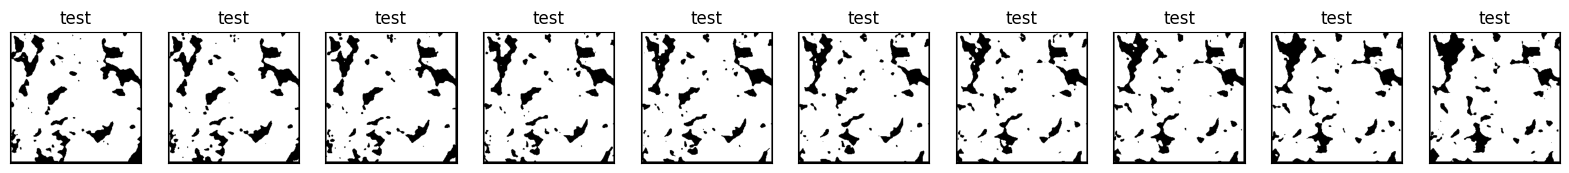

In [14]:
n = 10

plt.figure(figsize=(20,4))
for i in range(n):
    # original
    ax = plt.subplot(2,n,i+1)
    plt.imshow(voxels[0][i])
    plt.title('test')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
